# 🧪 Task: Convert a Single-Layer Perceptron (SLP) into a Multi-Layer Perceptron (MLP)

You are given a working implementation of a Single-Layer Perceptron (SLP).  
Your goal is to **extend it into a Multi-Layer Perceptron (MLP)** with **one hidden layer**.  
You need to modify the following functions:

---

## 1. `initialize_weights(self)`

**SLP:** Initializes a single weight matrix from input to output.  
**MLP:** You need to initialize **two weight matrices**:
- `W1`: connects **input → hidden layer**
- `W2`: connects **hidden layer → output layer**

📌 **Hint:** Use small random values.


## 2. `forward(self, x, W1, W2, no_gradient=False)`

**SLP:** Computes output directly: `a = sigmoid(Wᵀ · x)`  
**MLP:** Add hidden layer and activation:

📌 **Hint:** If `no_gradient=False`, store intermediate variables for backpropagation:


## 3. `back_prop(self, y, W2)`

**SLP:** Only computes one gradient.  
**MLP:** Use chain rule for backpropagation:

📌 **Hint:** Use `self.relu_derivative(z1)` for computing `ReLU'(z1)`.


## 4. `update_weights(self, W1, W2, grad_W1, grad_W2, learning_rate)`

📌 **Hint:** Update both W1 and W2.


## 5. `train(self)`

Update the following parts in `train()`:
- Replace `initialize_weights()` to return `W1, W2`
- Call updated `forward(x, W1, W2, ...)`
- Call new `back_prop(y, W2)`
- Update both `W1` and `W2` with `update_weights(...)`

📌 Evaluate the model using updated `forward()` at each epoch.


## Sample Code for SLP:

In [1]:
# import necessary libs
import random
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# random seed
random.seed(int(time.time()))
np.random.seed(int(time.time()))

In [2]:
#define dataloader, You have to put the Iris DataSet at the same path.
class Dataloader():
    def __init__(self, normalization=False):
        self.cross_val_flag = 0
        # Read data from iris.data
        datalist = self.load_data()
        # Shuffle data
        self.shuffle_data(datalist)
        # Split into 5 folds
        self.splited = self.split(datalist, 5)
        self.datas, self.labels = self.convert_list(self, self.splited)
        if normalization:
            self.data_normalization()
        self.a = 0

    # Cross-Valication here
    def get_Train_test_data(self):
        temp_data = np.ones((30, 4))
        temp_labels = np.ones(30)
        test_data = np.ones((30, 4))
        test_labels = np.ones(30)
        for i in range(5):
            if self.cross_val_flag != i:
                temp_data = np.vstack((temp_data, self.datas[i]))
                temp_labels = np.hstack((temp_labels, self.labels[i]))
            else:
                test_data = np.vstack((test_data, self.datas[i]))
                test_labels = np.hstack((test_labels, self.labels[i]))
        self.cross_val_flag += 1 if self.cross_val_flag < 4 else 0
        return temp_data[30:, :], temp_labels[30:], test_data[30:, :], test_labels[30:]

    # One-hot encoding labels
    @staticmethod
    def one_hot_mapping(labels: np.ndarray, num_classes: int):
        labels = labels.astype(int)
        num_labels = len(labels.tolist())
        # Generate all zero one-hot Martix
        labels_one_hot = np.zeros((num_labels, num_classes))
        # Calculate each class's offset position in finally Matrix
        index_offset = np.arange(num_labels) * num_classes
        # Go through Matrix, put 1 in each position
        # Output value setting, may set to 0.99 practical experience
        labels_one_hot.flat[index_offset + labels] = 0.99
        return labels_one_hot

    # Load the data, each row is a object.
    @staticmethod
    def load_data():
        root = "Iris DataSets/iris.data"
        datalist = []
        with open(root, "r") as f:
            for line in f:
                if line == "\n" or line == "":
                    break
                else:
                    datalist.append(line.replace("\n", ""))
        return datalist

    # Shuffle the dataset
    @staticmethod
    def shuffle_data(datalist: list):
        random.shuffle(datalist)
        return datalist

    # Split into 5 sub-datasets
    @staticmethod
    def split(datalist: list, splict_fold_num=5):
        length = len(datalist)
        splited = []
        fold_size = length / splict_fold_num
        for i in range(splict_fold_num):
            temp = []
            for j in range(int(i * fold_size), int((i + 1) * fold_size)):
                temp.append(datalist[j])
            splited.append(temp)
        return splited

    # Change the str labels to int labels
    @staticmethod
    def convert_strlabel_to_numlabel(label: str):
        # Mapping classes into numbers
        num_class_mapping = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
        for key, value in num_class_mapping.items():
            if key == label:
                return int(value)

    # Modify the data form to List [np0, np1, np2, np3, np4]
    # Convert list to ndarray
    @staticmethod
    def convert_list(self, splited: list):
        datas = []
        labels = []
        for i in range(5):
            data = np.empty([30, 4])
            label = np.empty([30, ])
            for j in range(30):
                temp = splited[i][j].split(",")
                data[j][0], data[j][1] = temp[0], temp[1]
                data[j][2], data[j][3] = temp[2], temp[3]
                # label convert to num
                label[j] = self.convert_strlabel_to_numlabel(temp[4])
            datas.append(data)
            labels.append(label)
        return datas, labels

    def data_normalization(self):
        x = np.zeros_like(self.datas[0])
        for i in range(len(self.datas)):
            x = np.vstack((x, self.datas[i]))
        x = x[30:, :]
        for i in range(4):
            # calculate mean and std
            mean = np.mean(x[:, i])
            std = np.std(x[:, i])
            # Do data Normalization
            for j in range(len(self.datas)):
                self.datas[j][:, i] -= mean
                self.datas[j][:, i] /= std


In [3]:
#define SLP
class SLP():
    def __init__(self, dataloader: Dataloader, epoch: int, learning_rate: float, gamma=1, ):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.gamma = gamma  # learning_rate decay hyperparameter gamma
        self.epoch = epoch

        self.weights1_list = []

        # Metrics
        self.train_loss = []
        self.train_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

        # Dataloader
        self.dataloader = dataloader
        self.inter_variable = {}

        # Gradient Descent Parameter
        self.momentum_v_layer1 = 0
        self.momentum_beta = 0.9

    def initialize_weights(self):
        w1 = np.random.rand(5, 3) * 2 - 1
        return w1

    def forward(self, x, w1, no_gradient: bool):
        z1 = w1.T.dot(x)
        a1 = 1 / (1 + np.exp(-z1))
        if no_gradient:
            # for predict
            return a1
        else:
            # For back propagation
            self.inter_variable = {"z1": z1, "a1": a1}
            return a1

    def back_prop(self, x, y):
        delta_k = self.inter_variable["a1"] - y.T
        delta_j = self.inter_variable["a1"] * \
                  (1 - self.inter_variable["a1"]) * delta_k
        gradient1 = x.dot(delta_j.T)
        return gradient1

    def update_weight(self, w1, gradient1, learning_rate):
        w1 -= learning_rate * gradient1
        return w1, learning_rate

    def update_learning_rate(self, learning_rate):
        # Learning rate decay
        learning_rate *= self.gamma
        return learning_rate

    @staticmethod
    def accuracy(label, y_hat: np.ndarray):
        y_hat = y_hat.T
        acc = y_hat.argmax(axis=1) == label.argmax(axis=1)
        b = acc + 0
        return b.mean()

    def save(self, filename):
        np.savez(filename, self.weights1_list)

    @staticmethod
    def loss(output, label):
        return np.sum(((output.T - label) ** 2)) / (2 * label.shape[0])

    def train(self):
        start = time.time()
        # Do 5 fold corss validation
        for i in range(5):
            with tqdm(total=self.epoch) as _tqdm:
                _tqdm.set_description('5_Fold: {}/{}'.format(i + 1, 5))

                # Get data, everytime call this function, do cross validation load data
                learning_rate = self.learning_rate
                train_data, train_labels, test_data, test_labels = self.dataloader.get_Train_test_data()

                # Add one dimension for b
                train_data = np.c_[train_data, np.ones(train_data.shape[0])].T
                test_data = np.c_[test_data, np.ones(test_data.shape[0])].T

                train_labels = self.dataloader.one_hot_mapping(train_labels, 3)
                test_labels = self.dataloader.one_hot_mapping(test_labels, 3)

                # initialize weights
                w1 = self.initialize_weights()

                # put each cross validation metrics here
                temp_train_accuracy = []
                temp_train_loss = []
                temp_test_accuracy = []
                temp_test_loss = []
                for j in range(self.epoch):
                    for k in range(train_data.shape[1]):
                        single_data = train_data[:, k].reshape((5, 1))
                        single_label = train_labels[k].reshape(1, 3)

                        # forward feed
                        output = self.forward(x=single_data, w1=w1, no_gradient=False)

                        # Calculate gradient
                        gradient1 = self.back_prop(x=single_data, y=single_label)

                        # Evaluate
                        train_accuracy = self.accuracy(single_label, output)
                        train_loss = self.loss(output, single_label)
                        test_forward = self.forward(test_data, w1, no_gradient=True)
                        test_accuracy = self.accuracy(test_labels, test_forward)
                        test_loss = self.loss(test_forward, test_labels)

                        # Data storage
                        temp_train_accuracy.append(train_accuracy)
                        temp_train_loss.append(train_loss)
                        temp_test_accuracy.append(test_accuracy)
                        temp_test_loss.append(test_loss)

                        # Update weights
                        w1, learning_rate = self.update_weight(w1, gradient1, learning_rate=learning_rate)
                    # Update learning rate every epoch
                    learning_rate = self.update_learning_rate(learning_rate)
                    _tqdm.set_postfix(learning_rate='{:.6f}'.format(learning_rate),
                                      train_loss='{:.6f}'.format(train_loss),
                                      train_accuracy='{:.6f}'.format(train_accuracy),
                                      test_loss='{:.6f}'.format(test_loss),
                                      test_accuracy='{:.6f}'.format(test_accuracy))
                    _tqdm.update(1)

            self.weights1_list.append(w1)
            self.train_accuracy.append(temp_train_accuracy)
            self.train_loss.append(temp_train_loss)
            self.test_accuracy.append(temp_test_accuracy)
            self.test_loss.append(temp_test_loss)

        end = time.time()
        sum = 0
        for i in range(len(self.test_accuracy)):
            sum += self.test_accuracy[i][-1]
        print(f"Average test accuracy:{sum / 5}")
        print(f"Trained time: {1000 * (end - start)} ms")

In [4]:
# Run SLP
# normalization:"True", "False"
dataloader = Dataloader(normalization=True)
# gamma is learning rate decay hyperparameter
SLP = SLP(dataloader=dataloader, epoch=2000, learning_rate=0.001, gamma=0.9998)
# training
SLP.train()

5_Fold: 2/5:  12%|█▏        | 248/2000 [00:00<00:06, 265.64it/s, learning_rate=0.000952, test_accuracy=0.833333, test_loss=0.151727, train_accuracy=1.000000, train_loss=0.065924]


KeyboardInterrupt: 

---

## MLP code for filling

In [3]:
class MLP():
    def __init__(self, dataloader, epoch: int, learning_rate: float, gamma=1, hidden_dim=10):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epoch = epoch
        self.hidden_dim = hidden_dim

        self.train_loss = []
        self.train_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

        self.dataloader = dataloader
        self.inter_variable = {}
        self.weights1_list = []

    def initialize_weights(self):
        # TODO: Initialize two sets of weights: W1 for input→hidden, W2 for hidden→output
        # w1 = np.random.rand(5, self.hidden_dim) * 2 - 1
        # w2 = np.random.rand(self.hidden_dim, 3) * 2 - 1
        #uniform initialization
        range = np.sqrt(6/(4+1+3))
        w1 = np.random.uniform(-range, range, (5, self.hidden_dim))
        w2 = np.random.uniform(-range, range, (self.hidden_dim, 3))
        return w1, w2

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, x, W1, W2, no_gradient=False):
        # TODO: Add one hidden layer between input and output. Save intermediate variables.
        a1 = W1.T.dot(x)
        z1 = self.relu(a1)
        a2 = W2.T.dot(z1)
        #softmax
        # z2 = np.exp(a2) / np.sum(np.exp(a2), axis=0)
        if no_gradient:
            return a2
        else:
            self.inter_variable = {"a1": a1, "z1": z1, "a2": a2}
            return a2

    def back_prop(self, x, y, W2):
        # TODO: Backpropagate through two layers: output and hidden. Use chain rule.
        # print("x:", x.shape, "y:", y.shape, "W2:", W2.shape)
        # print("a1:", self.inter_variable["a1"].shape, "z1:", self.inter_variable["z1"].shape, "a2:", self.inter_variable["a2"].shape)
        # a1: (20, 1) z1: (20, 1) a2: (3, 1)
        # x: (5, 1) y: (1, 3) W2: (20, 3)
        delta_E_a2 = self.inter_variable["a2"] - y.T  #(3, 1)
        delta_z1_a1 = self.relu_derivative(self.inter_variable["a1"])  #(20, 1)
        grad_W1 = x.dot((delta_z1_a1 * W2.dot(delta_E_a2)).T)
        grad_W2 = self.inter_variable["z1"].dot(delta_E_a2.T)
        return grad_W1, grad_W2

    def update_weights(self, W1, W2, grad_W1, grad_W2, learning_rate):
        # TODO: Update both sets of weights using gradients
        W1 -= learning_rate * grad_W1
        W2 -= learning_rate * grad_W2
        return W1, W2

    def update_learning_rate(self, learning_rate):
        return learning_rate * self.gamma

    @staticmethod
    def accuracy(label, y_hat):
        y_hat = y_hat.T
        return (y_hat.argmax(axis=1) == label.argmax(axis=1)).mean()

    @staticmethod
    def loss(output, label):
        return np.sum((output.T - label) ** 2) / (2 * label.shape[0])

    def train(self):
        start = time.time()
        for i in range(5):
            with tqdm(total= self.epoch) as _tqdm:
                _tqdm.set_description(f'5_Fold: {i + 1}/5')

                learning_rate = self.learning_rate
                train_data, train_labels, test_data, test_labels = self.dataloader.get_Train_test_data()

                train_data = np.c_[train_data, np.ones(train_data.shape[0])].T
                test_data = np.c_[test_data, np.ones(test_data.shape[0])].T

                train_labels = self.dataloader.one_hot_mapping(train_labels, 3)
                test_labels = self.dataloader.one_hot_mapping(test_labels, 3)

                W1, W2 = self.initialize_weights()

                temp_train_accuracy, temp_train_loss = [], []
                temp_test_accuracy, temp_test_loss = [], []

                best_epoch = 0
                best_accuracy = 0
                best_w1 = None
                best_w2 = None

                for j in range(self.epoch):
                    train_output = np.empty((train_labels.shape[0], 3))
                    for k in range(train_data.shape[1]):
                        single_data = train_data[:, k].reshape((5, 1))
                        single_label = train_labels[k].reshape(1, 3)

                        # TODO: Run forward pass using W1 and W2
                        output = self.forward(single_data, W1, W2, no_gradient=False)
                        train_output[k] = output.T

                        # TODO: Compute gradients using backpropagation through two layers
                        grad_W1, grad_W2 = self.back_prop(single_data, single_label, W2)

                        W1, W2 = self.update_weights(W1, W2, grad_W1, grad_W2, learning_rate)

                    # train_output = self.forward(train_data, W1, W2, no_gradient=False)]
                    train_output = train_output.T
                    train_accuracy = self.accuracy(train_labels, train_output)
                    train_loss = self.loss(train_output, train_labels)

                    test_output = self.forward(test_data, W1, W2, no_gradient=True)
                    test_accuracy = self.accuracy(test_labels, test_output)
                    test_loss = self.loss(test_output, test_labels)

                    temp_test_accuracy.append(test_accuracy)
                    temp_test_loss.append(test_loss)

                    if test_accuracy > best_accuracy:
                        best_epoch = j
                        best_accuracy = test_accuracy
                        best_w1 = W1
                        best_w2 = W2

                    learning_rate = self.update_learning_rate(learning_rate)
                    _tqdm.set_postfix(lr='{:.6f}'.format(learning_rate),
                                          train_loss='{:.6f}'.format(train_loss),
                                          train_accuracy='{:.6f}'.format(train_accuracy),
                                          test_loss='{:.6f}'.format(test_loss),
                                          test_accuracy='{:.6f}'.format(test_accuracy))
                    _tqdm.update(1)

                self.weights1_list.append((W1, W2))
                self.train_accuracy.append(temp_train_accuracy)
                self.train_loss.append(temp_train_loss)
                self.test_accuracy.append(temp_test_accuracy)
                self.test_loss.append(temp_test_loss)

            best_epoch = np.argmax(temp_test_accuracy)
            print(f"best accuracy at epoch {best_epoch}: {temp_test_accuracy[best_epoch]}, weights are taken from this epoch.")

            # plot test accuracy
            plt.plot(temp_test_accuracy, label=f'Fold {i + 1}')
            plt.xlabel('Epoch')
            plt.ylabel('Test Accuracy')
            plt.title(f'Training process at fold {i + 1}')
            plt.legend()
            plt.show()

        end = time.time()
        print(f"Average test accuracy: {np.mean([max(acc) for acc in self.test_accuracy])}")
        print(f"Trained time: {end - start} s")

5_Fold: 1/5: 100%|██████████| 2000/2000 [00:03<00:00, 619.15it/s, lr=0.000335, test_accuracy=0.933333, test_loss=0.073630, train_accuracy=1.000000, train_loss=0.019949]


best accuracy at epoch 61: 0.9666666666666667, weights are taken from this epoch.


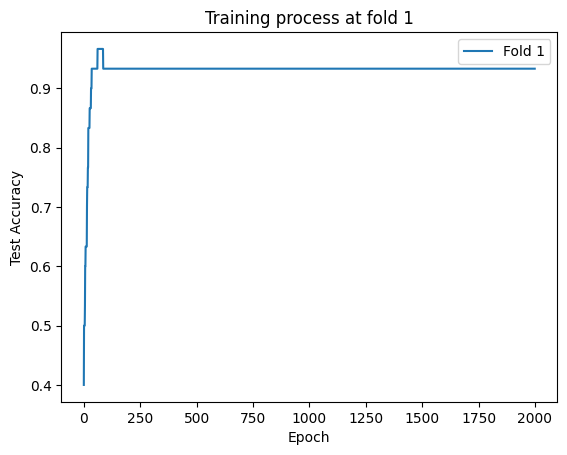

5_Fold: 2/5: 100%|██████████| 2000/2000 [00:03<00:00, 601.53it/s, lr=0.000335, test_accuracy=0.933333, test_loss=0.062186, train_accuracy=0.991667, train_loss=0.021617]


best accuracy at epoch 314: 0.9666666666666667, weights are taken from this epoch.


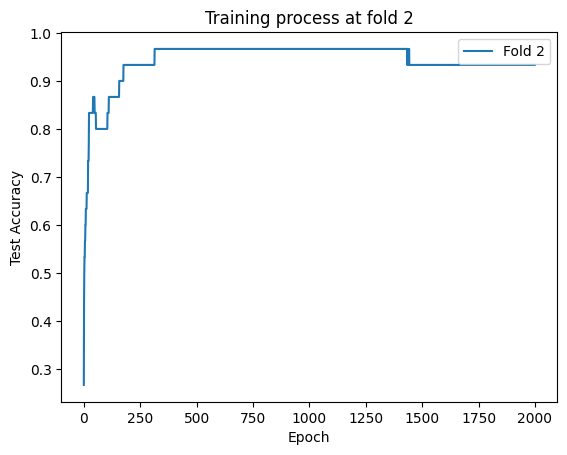

5_Fold: 3/5: 100%|██████████| 2000/2000 [00:03<00:00, 619.86it/s, lr=0.000335, test_accuracy=1.000000, test_loss=0.045499, train_accuracy=0.991667, train_loss=0.022864]


best accuracy at epoch 569: 1.0, weights are taken from this epoch.


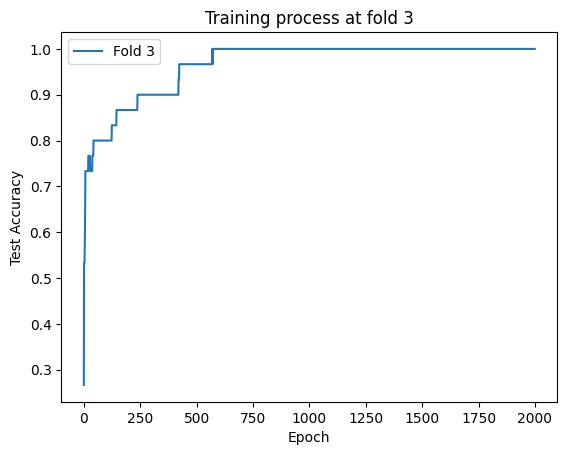

5_Fold: 4/5: 100%|██████████| 2000/2000 [00:03<00:00, 626.58it/s, lr=0.000335, test_accuracy=0.966667, test_loss=0.079865, train_accuracy=0.983333, train_loss=0.022002]


best accuracy at epoch 123: 0.9666666666666667, weights are taken from this epoch.


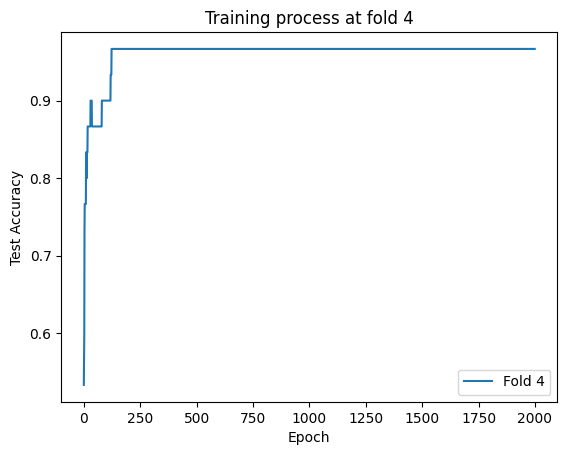

5_Fold: 5/5: 100%|██████████| 2000/2000 [00:03<00:00, 593.66it/s, lr=0.000335, test_accuracy=0.933333, test_loss=0.042752, train_accuracy=0.991667, train_loss=0.019261]


best accuracy at epoch 73: 0.9333333333333333, weights are taken from this epoch.


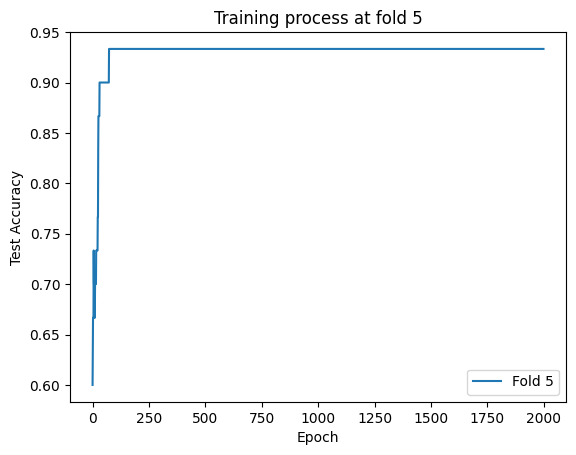

Average test accuracy: 0.9666666666666668
Trained time: 16.729252338409424 s


In [4]:
# Run MLP
# normalization:"True", "False"
dataloader = Dataloader(normalization=True)
# gamma is learning rate decay hyperparameter
mlp = MLP(dataloader=dataloader, epoch=2000, learning_rate=0.0005, gamma=0.9998,
          hidden_dim=50)  #tune different hidden unit!
# training
mlp.train()